In [2]:
!pip install dgl-cu113 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 MB 5.0 MB/s eta 0:00:0000:0100:01


In [3]:
import dgl
from dgl.data.utils import save_graphs, load_graphs
import torch

import pandas as pd
import numpy as np



Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


In [4]:
def product_data():
    prod_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
    prod_df = prod_df.reset_index()
    prod_df = prod_df.rename(columns={"index":"product_node_id"})

    # Group products under same index group + product group
    prod_df['article_id_str'] = prod_df['article_id'].astype(str)
    sim_idx_prdgpnm = prod_df.groupby(['index_group_name', 'product_group_name'])['article_id_str'].apply(lambda  x: ','.join(x)).reset_index()
    sim_idx_prdgpnm.to_parquet('./index_prod_group.parquet', index=False)

    ## Creating interactions between products of same index group + product group
    s = sim_idx_prdgpnm['article_id_str'].str.split(',').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1)
    s.name = 'article_id'
    s = s.reset_index()
    s['article_id'] = s['article_id'].astype(int)
    s = s.merge(prod_df[['article_id', 'product_node_id']], on = 'article_id')
    s.to_parquet('./sim_prod_interaction.parquet', index=False)

    ## Subsetting numerical values and replacing it with inverse frequency,
    subset_columns = ['product_node_id', 'article_id', 'product_code', 'product_type_no',
                      'graphical_appearance_no','colour_group_code',
                      'department_no','index_group_no', 'section_no',
                      'garment_group_no']
    prod_df = prod_df[subset_columns]
    norm_prod_df = prod_df.copy()
    for c in subset_columns[2:]:
        norm_prod_df[c] = norm_prod_df[c].map(dict(100/prod_df[c].value_counts()))
    norm_prod_df.to_parquet('./product.parquet', index=False)

    print('Done!')

    return  norm_prod_df

prod_df = product_data()




Done!


In [6]:
def user_data():
    user_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
    user_df['Active'] = user_df['Active'].fillna(value=0)
    user_df['FN'] = user_df['FN'].fillna(value=0)

    user_df['club_member_status'] = user_df['club_member_status'].fillna(value='NotAvailable')
    user_df['club_member_status'] = user_df['club_member_status'].astype('category').cat.codes

    user_df['fashion_news_frequency'] = user_df['fashion_news_frequency'].replace('None', 'NONE')
    user_df['fashion_news_frequency'] = user_df['fashion_news_frequency'].fillna(value='NONE')
    user_df['fashion_news_frequency'] = user_df['fashion_news_frequency'].astype('category').cat.codes

    user_df['age'] = user_df['age'].fillna(value=-1)

    user_df = user_df.reset_index()
    user_df = user_df.rename(columns={"index":"customer_node_id"})
    user_df.to_parquet('./user.parquet', index=False)
    print("Done!")
    return  user_df

user_df = user_data()

Done!


In [7]:
def decay_function(x):
    return np.exp(1)**(-(x**2)/2000)

def transaction_data(user_df, prod_df):

    prch_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
    prch_df['t_max'] = prch_df['t_dat'].max()
    prch_df['days_frm_prch'] = (pd.to_datetime(prch_df['t_max']) - pd.to_datetime(prch_df['t_dat'])).dt.days
    prch_df = prch_df[prch_df['days_frm_prch']<367]

    prch_df['decay_cost'] = np.round(prch_df['days_frm_prch'].map(decay_function), 3) + 0.01

    prch_df = prch_df[['customer_id', 'article_id', 'price', 'decay_cost']]

    prch_df = prch_df.merge(user_df[["customer_id","customer_node_id"]], on='customer_id', how='left').merge(prod_df[["article_id", "product_node_id"]], on='article_id', how='left')

    prch_df.to_parquet('./transaction.parquet', index=False)
    print('Done!')
    return prch_df

prch_df = transaction_data(user_df, prod_df)

Done!


# Making Graph

In [12]:
import dgl
import torch
import pandas as pd

from dgl.data.utils import save_graphs, load_graphs

In [13]:
customer_df = pd.read_parquet("./user.parquet")
product_df = pd.read_parquet("./product.parquet")
purchased_df = pd.read_parquet("./transaction.parquet")
sim_prod_df = pd.read_parquet("./sim_prod_interaction.parquet")

In [14]:
train_prch = purchased_df[purchased_df['decay_cost']<0.96]
test_prch = purchased_df[purchased_df['decay_cost']>=0.96]
print(train_prch.shape, test_prch.shape)

(14556269, 6) (376104, 6)


In [15]:
num_nodes = {"customer": customer_df.shape[0],
             "product": product_df.shape[0],
             "prod_group": sim_prod_df['index'].nunique()}

train_data_dict = {
    ("customer", "purchased", "product") : list(train_prch[["customer_node_id", "product_node_id"]].to_records(index=False)),
    ("product", "rev_purchased", "customer") : list(train_prch[["product_node_id", "customer_node_id"]].to_records(index=False)),
    ("product", "same_product_group", "prod_group"): list(sim_prod_df[['product_node_id', 'index']].to_records(index=False)),
    ("prod_group", "rev_same_product_group", "product"): list(sim_prod_df[['index', 'product_node_id']].to_records(index=False))
}

test_data_dict = {
    ("customer", "purchased", "product") : list(test_prch[["customer_node_id", "product_node_id"]].to_records(index=False)),
    ("product", "rev_purchased", "customer") : list(test_prch[["product_node_id", "customer_node_id"]].to_records(index=False)),
    ("product", "same_product_group", "prod_group"): list(sim_prod_df[['product_node_id', 'index']].to_records(index=False)),
    ("prod_group", "rev_same_product_group", "product"): list(sim_prod_df[['index', 'product_node_id']].to_records(index=False))

}


train_graph = dgl.heterograph(train_data_dict, num_nodes)

test_graph = dgl.heterograph(test_data_dict, num_nodes)

In [16]:
for c in ['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age']:
    customer_df[c] = customer_df[c].astype('float32')

for c in product_df.drop(['product_node_id', 'article_id'], axis=1).columns:
    product_df[c] = product_df[c].astype('float32')

# add node features

train_graph.ndata["feats"] = {"customer":torch.tensor(customer_df[['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age']].values),
                              "product":torch.tensor(product_df.drop(['product_node_id', 'article_id'], axis=1).values)}


test_graph.ndata["feats"] = {"customer":torch.tensor(customer_df[['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age']].values),
                          "product":torch.tensor(product_df.drop(['product_node_id', 'article_id'], axis=1).values)}

#add edge features

train_graph.edges["purchased"].data["price"] = torch.tensor(train_prch[["price"]].astype('float32').values)
train_graph.edges["purchased"].data["weight"] = torch.tensor(train_prch[["decay_cost"]].astype('float32').values)

train_graph.edges["rev_purchased"].data["price"] = torch.tensor(train_prch[["price"]].astype('float32').values)
train_graph.edges["rev_purchased"].data["weight"] = torch.tensor(train_prch[["decay_cost"]].astype('float32').values)


test_graph.edges["purchased"].data["price"] = torch.tensor(test_prch[["price"]].astype('float32').values)
test_graph.edges["purchased"].data["weight"] = torch.tensor(test_prch[["decay_cost"]].astype('float32').values)

test_graph.edges["rev_purchased"].data["price"] = torch.tensor(test_prch[["price"]].astype('float32').values)
test_graph.edges["rev_purchased"].data["weight"] = torch.tensor(test_prch[["decay_cost"]].astype('float32').values)


In [17]:
save_graphs("./hnm_train.bin", train_graph)
save_graphs("./hnm_test.bin", test_graph)

In [18]:
print(f"Number of Nodes: {train_graph.num_nodes()}")
for ntype in train_graph.ntypes:
    print(f"{ntype} : {train_graph.num_nodes(ntype)}")

Number of Nodes: 1477583
customer : 1371980
prod_group : 61
product : 105542


In [19]:
print(f"Total edges: {train_graph.num_edges()}")
for etype in train_graph.etypes:
    print(f"{etype} : {train_graph.num_edges(etype)}")

Total edges: 29323622
purchased : 14556269
rev_same_product_group : 105542
rev_purchased : 14556269
same_product_group : 105542


# Loss and Metrics

In [20]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score


def compute_loss_bcelogits(pos_score, neg_score):

    # BCE with logits
    score = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
    bcelogits_loss = F.binary_cross_entropy_with_logits(score, labels)
    return bcelogits_loss

def compute_auc(pos_score, neg_score):

    score = torch.cat([pos_score, neg_score]).clone().cpu().detach().numpy()
    labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)]).clone().cpu().detach().numpy()

    roc_score = roc_auc_score(labels, score)
    return roc_score


def precision_k(y_pred, y_true, k=12):
    x = np.intersect1d(y_true, y_pred[:k])
    return len(x)/k


def relevence_k(y_pred, y_true, k=12):
    if y_pred[k-1] in y_true:
        return 1
    else:
        return 0


def avg_precision_k(y_pred, y_true, k=12):
    ap = 0.0
    n = len(y_pred)
    k = min(n, k)
    for i in range(1, k+1):
        ap += precision_k(y_true, y_pred, i) * relevence_k(y_true, y_pred, i)

    return ap/min(len(y_true), k)


def mean_avg_precision_k(y_true, y_pred, k=12):
    return np.mean([avg_precision_k(yt, yp, k) for yt, yp in zip(y_true, y_pred)])

# Model

In [21]:
from typing import Tuple

import dgl.function as fn
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F

class NodeEmbedding(nn.Module):
    def reset(self):
        nn.init.xavier_uniform_(self.proj_ip.weight)

    def __init__(self, in_feats: int, embd_dim: int, hid_units: int) -> None:
        super().__init__()
        self.proj_ip = nn.Linear(in_feats, embd_dim)
        self.proj_ip2 = nn.Linear(embd_dim, hid_units)
        self.lrelu = nn.LeakyReLU()
        self.reset()

    def forward(self, node_feats):
        x = self.proj_ip(node_feats)
        x = self.lrelu(self.proj_ip2(x))
        return x


class ConvLayer(nn.Module):
    """
    1 layer of message passing and aggregation
    """

    def reset_params(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_uniform_(self.fc_neigh.weight, gain)
        nn.init.xavier_uniform_(self.fc_self.weight, gain)

    def __init__(self,
                 in_feats: Tuple[int, int],
                 out_size: int,
                 aggregation: str,
                 dropout: float,
                 norm: bool):
        super().__init__()
        self._in_neigh_feats, self._in_self_feats = in_feats
        self.fc_neigh = nn.Linear(self._in_neigh_feats, out_size, bias=False)
        self.fc_self = nn.Linear(self._in_self_feats, out_size, bias=False)
        self.dropout_fn = nn.Dropout(dropout)
        self._aggregation = aggregation
        self.norm = norm
        self.reset_params()

    def forward(self, g, x):
        """
        g: input graph/blocks
        x: input features/node embeddings

        :output
        h: updated node embeddings after message passing and aggregation
        """

        h_neigh, h_self = x
        h_neigh = self.dropout_fn(h_neigh)
        h_self = self.dropout_fn(h_self)
        g.srcdata['h'] = h_neigh

        if self._aggregation == 'mean':
            g.update_all(
                fn.copy_src('h', 'm'),
                fn.mean('m', 'neigh'))
            h_neigh = g.dstdata['neigh']

        elif self._aggregation == 'sum':
            g.update_all(
                fn.copy_src('h', 'm'),
                fn.sum('m', 'neigh'))
            h_neigh = g.dstdata['neigh']

        else:
            raise KeyError(f'Aggregation function {self._aggregation} not supported...')

        z = F.relu(self.fc_self(h_self) + self.fc_neigh(h_neigh))

        if self.norm:
            z_norm = z.norm(2, 1, keepdim=True)
            z_norm = torch.where(z_norm == 0, torch.tensor(1.0).to(z_norm), z_norm)
            z = z / z_norm

        return z


class PredictionLayer(nn.Module):
    """:returns

    Neural Net to compute link score between customer and product
    """

    def reset_params(self):
        gain_relu = nn.init.calculate_gain('selu')
        gain_sigmoid = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_uniform_(self.hidden_layer1.weight, gain_relu)
        nn.init.xavier_uniform_(self.hidden_layer2.weight, gain_relu)
        nn.init.xavier_uniform_(self.output_layer.weight, gain_sigmoid)

    def __init__(self, embd_dim: int):
        super(PredictionLayer, self).__init__()
        self.hidden_layer1 = nn.Linear(embd_dim * 2, 16)
        self.hidden_layer2 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 1)
        self.relu = nn.SELU()
        self.sigmoid = nn.Sigmoid()
        self.reset_params()

    def forward(self, x):
        x = self.relu(self.hidden_layer1(x))
        x = self.relu(self.hidden_layer2(x))
        x = self.output_layer(x)
        #x = self.sigmoid(x)

        return x


class PredictionModule(nn.Module):

    def __init__(self, predicting_layer, embd_dim: int):
        super(PredictionModule, self).__init__()
        self.layer_nn = predicting_layer(embd_dim)

    def forward(self, g, h):
        score_dict = {}

        for src, etype, dst in g.canonical_etypes:
            if src in ['customer', 'product'] and dst in ['customer', 'product']:
                src_nid, dst_nid = g.all_edges(etype=etype)
                embd_head = h[src][src_nid]
                embd_tail = h[dst][dst_nid]
                cat_embd = torch.cat((embd_head, embd_tail), 1)
                score = self.layer_nn(cat_embd)
                score_dict[etype] = torch.flatten(score)

        #print(score_dict, score)
        score_dict = {key: torch.unsqueeze(score_dict[key], 1) for key in score_dict.keys()}
        return score_dict


class GNNModel(nn.Module):
    """:returns
    Combined model which includes embedding layer, conv layers and prediction layer.
    """

    def __init__(self,
                 g,
                 dim_dict,
                 n_layers: int = 2,
                 norm: bool = True,
                 dropout: float = 0.1,
                 aggregation: str = 'mean',
                 aggregator_hetero: str = 'sum'
                 ):
        super().__init__()

        self.customer_embd = NodeEmbedding(dim_dict['customer'], dim_dict['out'], dim_dict['hidden'])
        self.product_embd = NodeEmbedding(dim_dict['product'], dim_dict['out'], dim_dict['hidden'])
        self.prod_group_embd = NodeEmbedding(dim_dict['prod_group'], dim_dict['out'], dim_dict['hidden'])

        self.layers = nn.ModuleList()

        # connect embedding layer to hidden layer
        for i in range(n_layers - 1):
            self.layers.append(
                dglnn.HeteroGraphConv(
                    {etype: ConvLayer((dim_dict['hidden'], dim_dict['hidden']),
                                      dim_dict['hidden'],
                                      aggregation,
                                      dropout,
                                      norm)
                     for etype in g.etypes}, aggregate=aggregator_hetero)
            )

        # output layer
        self.layers.append(
            dglnn.HeteroGraphConv(
                {etype: ConvLayer((dim_dict['hidden'], dim_dict['hidden']),
                                  dim_dict['out'],
                                  aggregation,
                                  dropout,
                                  norm)
                 for etype in g.etypes}, aggregate=aggregator_hetero)
        )

        self.pred_fn = PredictionModule(PredictionLayer, dim_dict['out'])

    def get_node_representations(self, blocks, h):
        for i in range(len(blocks)):
            layer = self.layers[i]
            h = layer(blocks[i], h)
        return h

    def forward(self, blocks, h, pos_graph, neg_graph):
        h['customer'] = self.customer_embd(h['customer'])
        h['product'] = self.product_embd(h['product'])
        h['prod_group'] = self.prod_group_embd(h['prod_group'])
        h = self.get_node_representations(blocks, h)
        pos_score = self.pred_fn(pos_graph, h)
        neg_score = self.pred_fn(neg_graph, h)

        return h, pos_score, neg_score


# Util funtions

In [22]:
import os
import time

import dgl
import torch
import pandas as pd
import tqdm
import numpy as np
import math


def get_node_loader(g,
                    customer_ids,
                    all_product_ids,
                    prod_gp_ids,
                    pos_neigh_sample,
                    n_layers,
                    batch_size,
                    num_workers,
                    device):
    if device=='cuda':
        num_workers=0
    #sampler = dgl.dataloading.MultiLayerNeighborSampler([pos_neigh_sample, pos_neigh_sample])
    sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers)

    nodeloader = dgl.dataloading.DataLoader(
        graph=g,
        indices={'customer': torch.tensor(customer_ids, device=device), 'product': torch.tensor(all_product_ids, device=device), 'prod_group': torch.tensor(prod_gp_ids, device=device)},
        graph_sampler=sampler,
        batch_size=batch_size,
        device=device,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers
    )

    return nodeloader


def get_embeddings(g,
                   out_dim,
                   trained_model,
                   nodeloader,
                   device):

    y = {ntype: torch.empty(g.number_of_nodes(ntype), out_dim, device=device) for ntype in g.ntypes}
    trained_model = trained_model.to(device)
    trained_model.eval()

    with tqdm.tqdm(nodeloader) as tq, torch.no_grad():
        for step, (input_nodes, output_nodes, blocks) in enumerate(tq):
            blocks = [b.to(device) for b in blocks]

            input_features = blocks[0].srcdata['feats']
            input_features['customer'] = trained_model.customer_embd(input_features['customer']).to(device)
            input_features['product'] = trained_model.product_embd(input_features['product']).to(device)
            input_features['prod_group'] = trained_model.prod_group_embd(input_features['prod_group']).to(device)

            h = trained_model.get_node_representations(blocks, input_features)
            for ntype in h.keys():
                if ntype in output_nodes.keys():
                    y[ntype][output_nodes[ntype]] = h[ntype]

    return y


def get_preds_parallel(h, user_ids, model, embd_dim, device, k=12):

    input_node = [i for i in user_ids]

    #print(input_node)
    with torch.no_grad():
        model = model.to(device)
        model.eval()

        user_embd_rpt = torch.repeat_interleave(h['customer'][input_node], h['product'].shape[0], dim=0)
        prd_embd_rpt = torch.cat([h['product']] * len(input_node)).reshape(-1, embd_dim)
        cat_embd = torch.cat((user_embd_rpt, prd_embd_rpt), 1).to(device)
        #print(cat_embd.shape)
        scores = model.pred_fn.layer_nn(cat_embd.to(device))
        #print(scores.shape)
        formatted_score = scores.reshape(len(input_node), h['product'].shape[0])
        prod_node_id = torch.topk(formatted_score, k=k).indices
        temp = pd.concat([pd.DataFrame(input_node), pd.DataFrame(prod_node_id.cpu().numpy())], axis=1)
        #print(temp)
        temp.to_csv('./temp.csv', index=False, mode='a', header=None)


def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx+n, l)]

def get_scores(g,
               h,
               model,
               user_ids,
               embd_dim,
               device,
               batch_size,
               k: int =12):

    batch_size = batch_size
    recs = []
    if os.path.exists("./temp.csv"):
        os.remove("./temp.csv")

    #predictdataset = PredictNodeLoaderDataset(user_ids, h)
    #user_ids = torch.utils.data.DataLoader(predictdataset, batch_size=32, num_workers=2)

    uids = batch(user_ids, batch_size)
    total_batches = int(len(user_ids)/batch_size) + 1
    
    with tqdm.tqdm(uids, total=total_batches) as tq:
        for step, i in enumerate(tq):
            get_preds_parallel(h, i, model, embd_dim, device, k=k)
        #    if step % 50 == 0:
        #        print(f"batch {step+1} of {total_batches} done...")


    recs = pd.read_csv('./temp.csv', header=None)
    
    cols = ['cnid']
    for i in range(100):
        cols.append('p'+str(i))

    recs.columns = cols

    customer_df = pd.read_parquet("./user.parquet")
    product_df = pd.read_parquet("./product.parquet")

    pmap = product_df.set_index('product_node_id').to_dict()['article_id']
    cmap = customer_df.set_index('customer_node_id').to_dict()['customer_id']

    for i in cols[1:]:
        recs[i] = recs[i].map(pmap)

    recs['cnid'] = recs['cnid'].map(cmap)

    temp = pd.DataFrame(recs.drop('cnid', axis=1).apply(lambda x: ','.join(x.astype(str)), axis=1))
    temp.columns = ['prediction']
    temp['customer_id'] = recs['cnid']
    
    # Reorder columns to make 'customer_id' the first column
    temp = temp[['customer_id', 'prediction']]
    
    temp.to_csv("./submission.csv", index=False)

    return temp


# Training model

In [23]:
import dgl.dataloading
from dgl.data.utils import load_graphs


import torch.nn.utils
import tqdm

In [24]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
use_amp = False

print(device)

cuda


In [25]:
def get_pred_scores(g, config, model, customer_ids):

    product_ids = list(np.arange(g.number_of_nodes('product')).astype('int64'))
    prod_gp_ids = list(np.arange(g.number_of_nodes('prod_group')).astype('int64'))

    print(f"getting node loader for users:{len(customer_ids)} and products: {len(product_ids)} and product groups: {len(prod_gp_ids)}")
    nodeloader = get_node_loader(g, customer_ids=customer_ids,
                                 all_product_ids=product_ids,
                                 prod_gp_ids=prod_gp_ids,
                                 pos_neigh_sample=config["sample_neigh"],
                                 n_layers=config["n_layers"],
                                 batch_size=config['batch_size'],
                                 num_workers=2,
                                 device='cuda')
    print(f"getting node embeddings...")
    node_embds = get_embeddings(g,
                                out_dim=config['embd_dim'],
                                trained_model=model,
                                nodeloader=nodeloader,
                                device='cuda')
    
    #node_embds = {'customer': node_embds['customer'].detach(),
    #              'product': node_embds['product'].detach(),
    #              'prod_group': node_embds['prod_group'].detach()}

    print(f"getting scores...")
    scores = get_scores(g,
                        h=node_embds,
                        model=model,
                        user_ids=customer_ids,
                        embd_dim=config['embd_dim'],
                        device='cuda',
                        batch_size=32,
                        k=12)
    return scores

def evaluate(pred_df):
    prch_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
    prch_df = prch_df[prch_df['t_dat']>='2020-09-01']
    prch_df = prch_df.groupby('customer_id').apply(lambda x: str(x['article_id'].values).replace('\n', '')[1:-1]).reset_index()
    prch_df.columns = ['customer_id', 'purchases']
    pred_df = pred_df.merge(prch_df, on='customer_id')

    print(f"MAP@12: {mean_avg_precision_k(pred_df['purchases'], pred_df['prediction'], k=12)}")
    print(f"MAP@24: {mean_avg_precision_k(pred_df['purchases'], pred_df['prediction'], k=24)}")
    print(f"MAP@36: {mean_avg_precision_k(pred_df['purchases'], pred_df['prediction'], k=36)}")
    print(f"MAP@48: {mean_avg_precision_k(pred_df['purchases'], pred_df['prediction'], k=48)}")
    print(f"MAP@60: {mean_avg_precision_k(pred_df['purchases'], pred_df['prediction'], k=60)}")
    print(f"MAP@72: {mean_avg_precision_k(pred_df['purchases'], pred_df['prediction'], k=72)}")
    print(f"MAP@100: {mean_avg_precision_k(pred_df['purchases'], pred_df['prediction'], k=100)}")

def get_graphs():
    print("loading training graph")
    glist, _ = load_graphs("./hnm_train.bin")
    g = glist[0].to(device)

    g.ndata['feats'] = {'prod_group': torch.randn(g.number_of_nodes("prod_group"), 16, device=device)}

    for ntype in g.ntypes:
        print(f"{ntype}: {g.num_nodes(ntype)}")
        print(f"{ntype} : {g.node_attr_schemes(ntype)}")
        print("")

    for etype in g.etypes:
        print(f"{etype}: {g.num_edges(etype)}")
        print(f"{etype} : {g.edge_attr_schemes(etype)}")
        print("")

    print("loading validation graph")
    glist, _ = load_graphs("./hnm_test.bin")
    test_g = glist[0].to(device)

    test_g.ndata['feats'] = {'prod_group': g.ndata['feats']['prod_group']}

    for ntype in test_g.ntypes:
        print(f"{ntype}: {test_g.number_of_nodes(ntype)}")
        print(f"{ntype} : {test_g.node_attr_schemes(ntype)}")
        print("")

    for etype in test_g.etypes:
        print(f"{etype}: {test_g.num_edges(etype)}")
        print(f"{etype} : {test_g.edge_attr_schemes(etype)}")
        print("")
    
    return g, test_g


def get_data_loaders(config, g, test_g):
    train_eid_dict = {etype: g.edges(etype=etype, form='eid') for etype in g.canonical_etypes}
    test_eid_dict = {etype: test_g.edges(etype=etype, form='eid') for etype in test_g.canonical_etypes}

    neg_neigh_sample = config["sample_neigh"]
    pos_neigh_sample = config["sample_neigh"]

    negative_sampler = dgl.dataloading.negative_sampler.Uniform(neg_neigh_sample)

    sampler = dgl.dataloading.MultiLayerNeighborSampler(config["n_layers"]*[pos_neigh_sample])
    sampler = dgl.dataloading.as_edge_prediction_sampler(sampler=sampler, negative_sampler=negative_sampler,
                                                         exclude='reverse_types',
                                                         reverse_etypes={'purchased': 'rev_purchased', 'rev_purchased': 'purchased',
                                                                         'rev_same_product_group':'same_product_group', 'same_product_group':'rev_same_product_group'},
                                                         )

    train_dataloader = dgl.dataloading.DataLoader(

        g, 
        train_eid_dict,  
        sampler,  
        device='cuda', 
        
        batch_size=config["batch_size"], 
        shuffle=True,  
        drop_last=False,  
        num_workers=0  
    )

    test_dataloader = dgl.dataloading.DataLoader(
        test_g,  
        test_eid_dict,  
        sampler,  
        device='cuda', 
        batch_size=config["batch_size"],  
        shuffle=True,  
        drop_last=False,  
        num_workers=0  
    )
    return train_dataloader, test_dataloader


def train_model(config, model, checkpoint, train_dataloader, test_dataloader):
    epochs = config["epochs"]

    print(f"model parameters: {sum(p.numel() for p in model.parameters())}")
    model.to(device)
    try:
        opt = torch.optim.Adam(list(model.parameters()), lr=config["lr"])
        opt.load_state_dict(checkpoint['optimizer'])
        scaler = torch.cuda.amp.GradScaler()
        scaler.load_state_dict(checkpoint['scaler'])
        print('couldnt load checkpoint')
    except:
        opt = torch.optim.Adam(list(model.parameters()), lr=config["lr"])
        scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        print(f'Epoch: {epoch}')
        roc_Score = []
        with tqdm.tqdm(train_dataloader) as tq:
            for step, (input_nodes, pos_graph, neg_graph, mfgs) in enumerate(tq):
                with torch.cuda.amp.autocast(enabled=use_amp):
                    mfgs = [b.to(torch.device(device)) for b in mfgs]
                    pos_graph = pos_graph.to(torch.device(device))
                    neg_graph = neg_graph.to(torch.device(device))

                    inputs = mfgs[0].srcdata['feats']
                    _, pos_score, neg_score = model(mfgs, inputs, pos_graph, neg_graph)
                    
                    loss = compute_loss_bcelogits(pos_score['purchased'], neg_score['purchased'])
                    roc_score = compute_auc(pos_score['purchased'], neg_score['purchased'])
                roc_Score.append(roc_score)
                scaler.scale(loss).backward()

                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config["clip_grad_value"])

                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)

                tq.set_postfix({'loss': '%.03f' % loss, 'roc':'%.03f' % roc_score}, refresh=False)
        
        troc_Score = []
        with tqdm.tqdm(test_dataloader) as test_tq:
            for step, (input_nodes, pos_graph, neg_graph, mfgs) in enumerate(test_tq):
                with torch.cuda.amp.autocast(enabled=use_amp):
                    mfgs = [b.to(torch.device(device)) for b in mfgs]
                    pos_graph = pos_graph.to(torch.device(device))
                    neg_graph = neg_graph.to(torch.device(device))

                    inputs = mfgs[0].srcdata['feats']
                    _, pos_score, neg_score = model(mfgs, inputs, pos_graph, neg_graph)
                    
                    loss = compute_loss_bcelogits(pos_score['purchased'], neg_score['purchased'])
                    troc_score = compute_auc(pos_score['purchased'], neg_score['purchased'])
                troc_Score.append(troc_score)
                scaler.scale(loss).backward()

                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config["clip_grad_value"])

                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)

                tq.set_postfix({'loss': '%.03f' % loss, 'roc':'%.03f' % troc_score}, refresh=False)
        
        print(f"epoch {epoch}, Train ROC: {np.nanmean(roc_Score)}, Test ROC: {np.nanmean(troc_Score)}")

        checkpoint = {'model': model.state_dict(),
                      'optimizer': opt.state_dict(),
                      'scaler': scaler.state_dict()}
        
        torch.save(checkpoint, './model_checkpoint_'+str(epoch)+'.pt')
        
    torch.save(checkpoint, './best_model_checkpoint.pt')

    return model


In [23]:
def main(epochs,
         lr,
         sample_n,
         batch_size,
         hidden_units,
         embd_dim,
         train_new_model,
         n_layers: int = 2):
    
    config = {
        "lr": lr,
        "epochs": epochs,
        "sample_neigh": sample_n,
        "batch_size": batch_size,
        "hidden_units": hidden_units,
        "embd_dim": embd_dim,
        "clip_grad_value": 5,
        "n_layers": n_layers
    }

    g, test_g = get_graphs()

    train_dataloader, test_dataloader = get_data_loaders(config, g, test_g)

    dim_dict = {"customer": g.ndata['feats']['customer'].shape[1],
                "product": g.ndata['feats']['product'].shape[1],
                "prod_group": g.ndata['feats']['prod_group'].shape[1],
                "hidden": config["hidden_units"],
                "out": config["embd_dim"]}

    model = GNNModel(g, dim_dict, n_layers=n_layers)
    model = model.to(torch.device(device))
    print(model)
    if train_new_model:
        checkpoint = {}
        model = train_model(config=config,
                            model=model,
                            checkpoint=checkpoint,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader)

    try:
        model_checkpoint = "./best_model_checkpoint.pt"
        print(f"loading model from {model_checkpoint}")
        checkpoint = torch.load(model_checkpoint)
        model.load_state_dict(checkpoint['model'])
        print(f"loaded saved model!")
    except:
        print(f"No saved model found...training new")
        checkpoint = {}
        model = train_model(config=config,
                            model=model,
                            checkpoint=checkpoint,
                            train_dataloader=train_dataloader, test_dataloader=test_dataloader)

    #print(model)
    customer_ids = list(np.arange(g.number_of_nodes('customer')).astype('int64'))
    #customer_ids = list(np.arange(100).astype('int64'))

    scores = get_pred_scores(g, config=config, model=model, customer_ids=customer_ids)

    evaluate(scores)

In [24]:
main(epochs=2,
     lr=0.021,
     sample_n=10,
     batch_size=4096,
     hidden_units=32,
     embd_dim=64,
     train_new_model=True,
     n_layers= 2)

loading training graph
customer: 1371980
customer : {'feats': Scheme(shape=(5,), dtype=torch.float32)}

prod_group: 61
prod_group : {'feats': Scheme(shape=(16,), dtype=torch.float32)}

product: 105542
product : {'feats': Scheme(shape=(8,), dtype=torch.float32)}

purchased: 14556269
purchased : {'weight': Scheme(shape=(1,), dtype=torch.float32), 'price': Scheme(shape=(1,), dtype=torch.float32)}

rev_same_product_group: 105542
rev_same_product_group : {}

rev_purchased: 14556269
rev_purchased : {'weight': Scheme(shape=(1,), dtype=torch.float32), 'price': Scheme(shape=(1,), dtype=torch.float32)}

same_product_group: 105542
same_product_group : {}

loading validation graph
customer: 1371980
customer : {'feats': Scheme(shape=(5,), dtype=torch.float32)}

prod_group: 61
prod_group : {'feats': Scheme(shape=(16,), dtype=torch.float32)}

product: 105542
product : {'feats': Scheme(shape=(8,), dtype=torch.float32)}

purchased: 376104
purchased : {'weight': Scheme(shape=(1,), dtype=torch.float32), 

100%|██████████| 236/236 [00:18<00:00, 13.06it/s]


epoch 0, Train ROC: 0.9056592974318372, Test ROC: 0.9813892387632053
Epoch: 1


100%|██████████| 236/236 [00:18<00:00, 12.45it/s]


epoch 1, Train ROC: 0.9207505192215768, Test ROC: 0.9832323032900053
loading model from ./best_model_checkpoint.pt
loaded saved model!
getting node loader for users:1371980 and products: 105542 and product groups: 61
getting node embeddings...


100%|██████████| 361/361 [00:35<00:00, 10.27it/s]


getting scores...


100%|██████████| 42875/42875 [26:24<00:00, 27.06it/s]


MAP@12: 6.2539453600611335e-06
MAP@24: 6.2539453600611335e-06
MAP@36: 6.2539453600611335e-06
MAP@48: 6.2539453600611335e-06
MAP@60: 6.2539453600611335e-06
MAP@72: 6.2539453600611335e-06
MAP@100: 6.2539453600611335e-06


In [32]:
# For evaluation
'''
main(epochs=25,
     lr=0.021,
     sample_n=10,
     batch_size=4096,
     hidden_units=32,
     embd_dim=64,
     train_new_model=False,
     n_layers= 2)
'''
main(epochs=2,
     lr=0.021,
     sample_n=10,
     batch_size=4096,
     hidden_units=32,
     embd_dim=64,
     train_new_model=False,
     n_layers= 2)

loading training graph
customer: 1371980
customer : {'feats': Scheme(shape=(5,), dtype=torch.float32)}

prod_group: 61
prod_group : {'feats': Scheme(shape=(16,), dtype=torch.float32)}

product: 105542
product : {'feats': Scheme(shape=(8,), dtype=torch.float32)}

purchased: 14556269
purchased : {'weight': Scheme(shape=(1,), dtype=torch.float32), 'price': Scheme(shape=(1,), dtype=torch.float32)}

rev_same_product_group: 105542
rev_same_product_group : {}

rev_purchased: 14556269
rev_purchased : {'weight': Scheme(shape=(1,), dtype=torch.float32), 'price': Scheme(shape=(1,), dtype=torch.float32)}

same_product_group: 105542
same_product_group : {}

loading validation graph
customer: 1371980
customer : {'feats': Scheme(shape=(5,), dtype=torch.float32)}

prod_group: 61
prod_group : {'feats': Scheme(shape=(16,), dtype=torch.float32)}

product: 105542
product : {'feats': Scheme(shape=(8,), dtype=torch.float32)}

purchased: 376104
purchased : {'weight': Scheme(shape=(1,), dtype=torch.float32), 

100%|██████████| 361/361 [00:35<00:00, 10.26it/s]


getting scores...


100%|██████████| 42875/42875 [26:31<00:00, 26.95it/s]


MAP@12: 3.257263208365173e-07
MAP@24: 3.257263208365173e-07
MAP@36: 3.257263208365173e-07
MAP@48: 3.257263208365173e-07
MAP@60: 3.257263208365173e-07
MAP@72: 3.257263208365173e-07
MAP@100: 3.257263208365173e-07


In [31]:
print("Starting the pred game")
recs = pd.read_csv('./temp.csv', header=None)


cols = ['cnid']
for i in range(12):
    cols.append('p'+str(i))

recs.columns = cols

customer_df = pd.read_parquet("./user.parquet")
product_df = pd.read_parquet("./product.parquet")

pmap = product_df.set_index('product_node_id').to_dict()['article_id']
cmap = customer_df.set_index('customer_node_id').to_dict()['customer_id']

for i in cols[1:]:
    recs[i] = recs[i].map(pmap)

recs['cnid'] = recs['cnid'].map(cmap)

temp = pd.DataFrame(recs.drop('cnid', axis=1).apply(lambda x: ','.join(x.astype(str)), axis=1))
temp.columns = ['prediction']
temp['customer_id'] = recs['cnid']
temp.to_csv("./submission.csv", index=False)


Starting the pred game


In [26]:
scores = pd.read_csv('./submission.csv')
evaluate(scores)


MAP@12: 6.2539453600611335e-06
MAP@24: 6.2539453600611335e-06
MAP@36: 6.2539453600611335e-06
MAP@48: 6.2539453600611335e-06
MAP@60: 6.2539453600611335e-06
MAP@72: 6.2539453600611335e-06
MAP@100: 6.2539453600611335e-06


In [27]:
scores


,prediction,customer_id
0,"867969008,774113006,543556006,579541001,811378...",00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,"599580042,599580056,776237006,599580020,599580...",0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,"685814001,599580056,599580042,685814003,776237...",000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,"774113006,562245058,579541001,664074001,695632...",00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,"536139063,536139010,794321004,794321011,794321...",00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
...,...,...
1371975,"599580042,599580049,590928022,599580017,599580...",ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...
1371976,"599580036,599580020,776237004,599580042,599580...",ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...
1371977,"685814001,685814003,685813001,685813003,685813...",ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...
1371978,"852584001,724906019,815434001,748355017,724906...",ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...


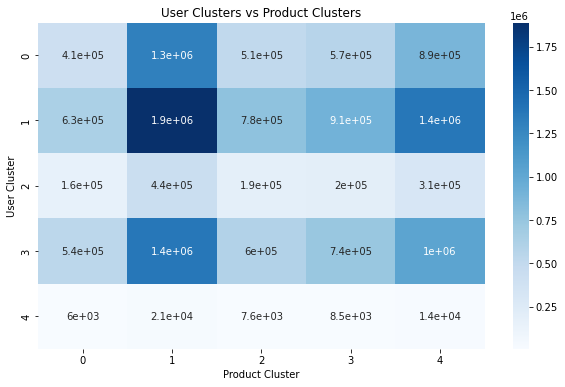

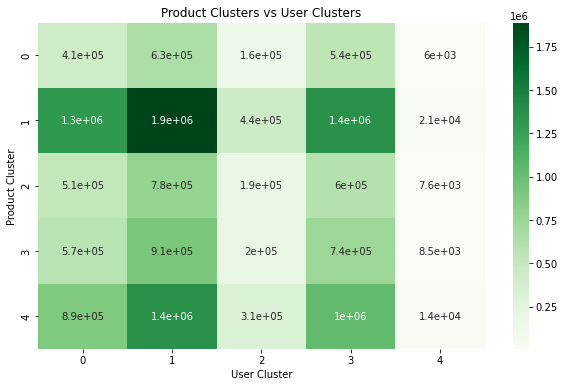

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


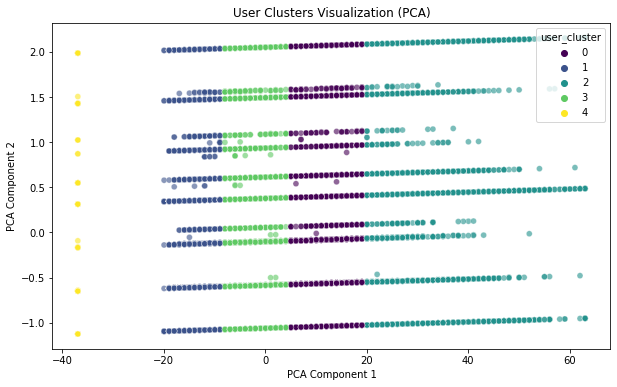

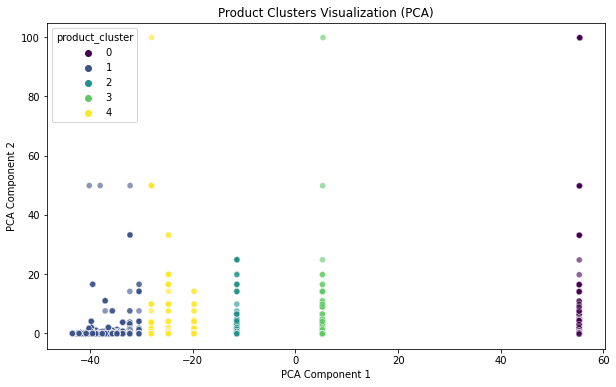

In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the transaction data and user/product data
customer_df = pd.read_parquet("./user.parquet")
product_df = pd.read_parquet("./product.parquet")
purchased_df = pd.read_parquet("./transaction.parquet")


user_features = customer_df[['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age']]
user_features = user_features.fillna(user_features.mean())
num_clusters_users = 5
kmeans_users = KMeans(n_clusters=num_clusters_users, random_state=42)
customer_df['user_cluster'] = kmeans_users.fit_predict(user_features)
product_features = product_df.drop(['product_node_id', 'article_id'], axis=1)
product_features = product_features.fillna(product_features.mean())
num_clusters_products = 5
kmeans_products = KMeans(n_clusters=num_clusters_products, random_state=42)
product_df['product_cluster'] = kmeans_products.fit_predict(product_features)
user_purchase_clusters = purchased_df.merge(customer_df[['customer_node_id', 'user_cluster']], on='customer_node_id')
user_purchase_clusters = user_purchase_clusters.merge(product_df[['product_node_id', 'product_cluster']], on='product_node_id')
user_cluster_summary = user_purchase_clusters.groupby(['user_cluster', 'product_cluster']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.heatmap(user_cluster_summary.pivot('user_cluster', 'product_cluster', 'count'), annot=True, cmap='Blues')
plt.title('User Clusters vs Product Clusters')
plt.xlabel('Product Cluster')
plt.ylabel('User Cluster')
plt.show()

product_cluster_summary = user_purchase_clusters.groupby(['product_cluster', 'user_cluster']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.heatmap(product_cluster_summary.pivot('product_cluster', 'user_cluster', 'count'), annot=True, cmap='Greens')
plt.title('Product Clusters vs User Clusters')
plt.xlabel('User Cluster')
plt.ylabel('Product Cluster')
plt.show()

pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=user_pca[:, 0], y=user_pca[:, 1], hue=customer_df['user_cluster'], palette='viridis', alpha=0.6)
plt.title('User Clusters Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

product_pca = pca.fit_transform(product_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=product_pca[:, 0], y=product_pca[:, 1], hue=product_df['product_cluster'], palette='viridis', alpha=0.6)
plt.title('Product Clusters Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()